# NLP Methods on Music Reviews
This project explores text preprocessing, lexicon normalization, and modeling of music reviews, retrieved from the Kaggle dataset [song reviews](https://www.kaggle.com/nolanbconaway/pitchfork-data)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import numpy as np
import seaborn as sns
import sqlite3
import string, re
import langdetect 
from textblob import TextBlob
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import * 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Khyatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Khyatee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Khyatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import Data
The data is stored as a series of tables within a sqlite database. The following cells extract each table and convert them to Pandas dataframes.

### Connect to the Database

In [2]:
connection = sqlite3.connect('datasets/reviews.sqlite')
cursor = connection.cursor()

### Reviews Table

In [3]:
query = "select * from reviews;"
cursor.execute(query)
df_reviews = pd.DataFrame(cursor.fetchall(), columns=["id",'track', 'artist', 'url','score',
    'best_new_music', 'author', 'author_type','date','weekday', 'day', 'month', 'year'])
df_reviews.head()

,id,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


### Content Table

In [4]:
query = "select * from content;"
cursor.execute(query)
df_content = pd.DataFrame(cursor.fetchall(), columns=["id",'review'])
df_content.head()

,id,review
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


### Genres Table

In [5]:
query = "select * from genres;"
cursor.execute(query)
df_genres = pd.DataFrame(cursor.fetchall(), columns=["id",'genre'])
df_genres.head()

,id,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


# Data Prep
The following cells perform text preprocessing steps, such as stop word / punctuation removal

## Merge Dataframes

In [6]:
df = df_content.merge(df_reviews, on='id')
df.sample(5)

,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
11598,10004,\r\n Brooklyn's Palomar makes indie-pop sou...,"all things, forests",palomar,http://pitchfork.com/reviews/albums/10004-all-...,7.4,0,brian howe,contributor,2007-03-22,3,22,3,2007
2588,19749,"Many bands these days, particularly of the fol...",venus armata,menace ruine,http://pitchfork.com/reviews/albums/19749-mena...,7.4,0,jason heller,contributor,2014-10-22,2,22,10,2014
3818,18554,If Staring at the X distanced Forest Fire from...,screens,forest fire,http://pitchfork.com/reviews/albums/18554-fore...,7.3,0,joel oliphint,contributor,2013-10-04,4,4,10,2013
17748,2166,"Hi kids! Welcome to ""Uncle Matt's Happy Time!""...","fetch the compass, kids",danielson famile,http://pitchfork.com/reviews/albums/2166-fetch...,6.8,0,matt lemay,contributor,2001-04-24,1,24,4,2001
16887,7111,"Hey, everybody-- it's summertime! Time for pu...",the egg,shiner,http://pitchfork.com/reviews/albums/7111-the-egg/,7.4,0,joe tangari,contributor,2002-06-26,2,26,6,2002


## Create target variable

In [7]:
df =df[(df.score>8) | (df.score<6)]

In [8]:
df['target']=np.where(df.score>8, 1,0)

In [9]:
df.target.value_counts()

0    3004
1    2980
Name: target, dtype: int64

In [10]:
df = df.loc[:,['review', 'target']]
reviews = df['review']
target = df['target']
df.head()

,review,target
0,"“Trip-hop” eventually became a ’90s punchline,...",1
3,Kleenex began with a crash. It transpired one ...,1
4,It is impossible to consider a given release b...,1
9,There were innumerable cameos at the Bad Boy F...,0
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1


## Stopword Removal

In [11]:
# define a function that removes stopwords
def remove_stopwords(article):
    tokens = nltk.word_tokenize(article)
    
    stopword_list = stopwords.words('english')
    stopword_list += list(string.punctuation)
    stopword_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
                "n't", "'s", "'re", '-', '–', '—','\r\n','\r','\n', '--']

    stopword_set = set(stopword_list)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopword_set]
    
    ## back to string from list
    text = " ".join(stopwords_removed)
    return text

In [12]:
df['stopped'] = df['review'].apply(lambda x: remove_stopwords(x))
df.head()

,review,target,stopped
0,"“Trip-hop” eventually became a ’90s punchline,...",1,trip-hop eventually became 90s punchline music...
3,Kleenex began with a crash. It transpired one ...,1,kleenex began crash transpired one night long ...
4,It is impossible to consider a given release b...,1,impossible consider given release footwork art...
9,There were innumerable cameos at the Bad Boy F...,0,innumerable cameos bad boy family reunion tour...
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,2006 life killer mike boasted hard-pressed fin...


## Language Detection

In [13]:
df['lang'] = df['review'].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

# drop non english reviews (only 5 of them, empty reviews)
df.drop(df[df['lang']!='en'].index, inplace=True)
df.head()

,review,target,stopped,lang
0,"“Trip-hop” eventually became a ’90s punchline,...",1,trip-hop eventually became 90s punchline music...,en
3,Kleenex began with a crash. It transpired one ...,1,kleenex began crash transpired one night long ...,en
4,It is impossible to consider a given release b...,1,impossible consider given release footwork art...,en
9,There were innumerable cameos at the Bad Boy F...,0,innumerable cameos bad boy family reunion tour...,en
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,2006 life killer mike boasted hard-pressed fin...,en


## Lemmatization
Create a function to lemmatize reviews, and apply it to each review with stopwords removed as a new column called "lemmed"

In [14]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer() 
    lemmed = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return(lemmed)

In [15]:
df['lemmed'] = df['stopped'].apply(lambda x: lemmatize(x))
df.head()

,review,target,stopped,lang,lemmed
0,"“Trip-hop” eventually became a ’90s punchline,...",1,trip-hop eventually became 90s punchline music...,en,trip-hop eventually became 90 punchline music-...
3,Kleenex began with a crash. It transpired one ...,1,kleenex began crash transpired one night long ...,en,kleenex began crash transpired one night long ...
4,It is impossible to consider a given release b...,1,impossible consider given release footwork art...,en,impossible consider given release footwork art...
9,There were innumerable cameos at the Bad Boy F...,0,innumerable cameos bad boy family reunion tour...,en,innumerable cameo bad boy family reunion tour ...
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,2006 life killer mike boasted hard-pressed fin...,en,2006 life killer mike boasted hard-pressed fin...


## Stemming
Create a function to stemm reviews, and apply it to each review with stopwords removed as a new column called "stemmed"

In [16]:
def stemm(text):
    stemmer = PorterStemmer()
    stemmed = ' '.join([stemmer.stem(word) for word in text.split()])
    return(stemmed)

In [17]:
df['stemmed'] = df['stopped'].apply(lambda x: stemm(x))
df.head()

,review,target,stopped,lang,lemmed,stemmed
0,"“Trip-hop” eventually became a ’90s punchline,...",1,trip-hop eventually became 90s punchline music...,en,trip-hop eventually became 90 punchline music-...,trip-hop eventu becam 90 punchlin music-press ...
3,Kleenex began with a crash. It transpired one ...,1,kleenex began crash transpired one night long ...,en,kleenex began crash transpired one night long ...,kleenex began crash transpir one night long fo...
4,It is impossible to consider a given release b...,1,impossible consider given release footwork art...,en,impossible consider given release footwork art...,imposs consid given releas footwork artist wit...
9,There were innumerable cameos at the Bad Boy F...,0,innumerable cameos bad boy family reunion tour...,en,innumerable cameo bad boy family reunion tour ...,innumer cameo bad boy famili reunion tour ofte...
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,2006 life killer mike boasted hard-pressed fin...,en,2006 life killer mike boasted hard-pressed fin...,2006 life killer mike boast hard-press find an...


### Flatten list of lists

In [60]:
flat_best_reviews = "".join(list(df['stopped'][df['target']==1]))
flat_worst_reviews = "".join(list(df['stopped'][df['target']==0]))


In [61]:
best_freq = FreqDist(flat_best_reviews.split())
worst_freq = FreqDist(flat_worst_reviews.split())

# Exploratory Data Analysis

## Bag of Words

In [62]:
best_freq.most_common(20)

[('like', 11948),
 ('album', 8745),
 ('music', 8523),
 ('one', 7614),
 ('band', 6755),
 ('songs', 5437),
 ('sound', 4766),
 ('song', 4751),
 ('even', 4701),
 ('record', 4331),
 ('new', 4283),
 ('time', 4251),
 ('first', 4166),
 ('two', 3363),
 ('way', 3278),
 ('guitar', 3252),
 ('sounds', 3245),
 ('much', 3233),
 ('would', 3228),
 ('rock', 3219)]

In [63]:
worst_freq.most_common(20)

[('like', 10444),
 ('album', 7030),
 ('one', 5329),
 ('band', 5123),
 ('music', 4562),
 ('songs', 4303),
 ('even', 4263),
 ('song', 3941),
 ('sound', 3440),
 ('much', 3156),
 ('record', 3073),
 ('new', 2876),
 ('time', 2773),
 ('could', 2641),
 ('rock', 2632),
 ('sounds', 2622),
 ('would', 2574),
 ('first', 2565),
 ('track', 2530),
 ('way', 2357)]

### Normalized Word Frequencies

In [64]:
best_reviews_total_word_count = sum(best_freq.values())
best_top_25 = best_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in best_top_25:
    normalized_frequency = word[1]/best_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

like 		 0.008311
album 		 0.006083
music 		 0.005929
one 		 0.005297
band 		 0.004699
songs 		 0.003782
sound 		 0.003315
song 		 0.003305
even 		 0.00327
record 		 0.003013
new 		 0.002979
time 		 0.002957
first 		 0.002898
two 		 0.002339
way 		 0.00228
guitar 		 0.002262
sounds 		 0.002257
much 		 0.002249
would 		 0.002245
rock 		 0.002239
also 		 0.002188
track 		 0.002185
could 		 0.002168
tracks 		 0.002089
still 		 0.002069


In [65]:
worst_reviews_total_word_count = sum(worst_freq.values())
worst_top_25 = worst_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in worst_top_25:
    normalized_frequency = word[1]/worst_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

like 		 0.009775
album 		 0.006579
one 		 0.004987
band 		 0.004795
music 		 0.00427
songs 		 0.004027
even 		 0.00399
song 		 0.003688
sound 		 0.00322
much 		 0.002954
record 		 0.002876
new 		 0.002692
time 		 0.002595
could 		 0.002472
rock 		 0.002463
sounds 		 0.002454
would 		 0.002409
first 		 0.002401
track 		 0.002368
way 		 0.002206
get 		 0.002147
still 		 0.002132
tracks 		 0.002127
two 		 0.002088
little 		 0.001989


## Word Clouds

In [66]:
top_words_best = [x[0] for x in best_freq.most_common(25)]
top_words_best_count = [x[1] for x in best_freq.most_common(25)]

top_words_worst = [x[0] for x in worst_freq.most_common(25)]
top_words_worst_count = [x[1] for x in worst_freq.most_common(25)]

In [67]:
from wordcloud import WordCloud
best_dictionary = dict(zip(top_words_best, top_words_best_count))
worst_dictionary = dict(zip(top_words_worst, top_words_worst_count))

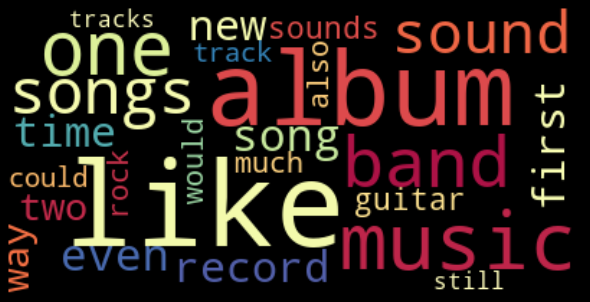

In [68]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(best_dictionary)

plt.figure(figsize=(8,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

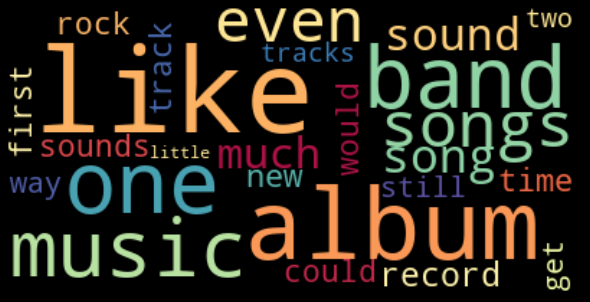

In [69]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(worst_dictionary)

plt.figure(figsize=(8,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Bigrams
### Raw Frequency

In [74]:
bigram_measures = nltk.collocations.BigramAssocMeasures() 

best_bigrams_finder = BigramCollocationFinder.from_words(flat_best_reviews.split())
worst_bigrams_finder = BigramCollocationFinder.from_words(flat_worst_reviews.split())

In [75]:
# bigram scores
scored_best = best_bigrams_finder.score_ngrams(bigram_measures.raw_freq)  
scored_worst = worst_bigrams_finder.score_ngrams(bigram_measures.raw_freq)


In [78]:
scored_best[:10]

[(('sounds', 'like'), 0.0006351092276570939),
 (('sound', 'like'), 0.00039929101497828247),
 (('title', 'track'), 0.0003624226808426571),
 (('new', 'york'), 0.0003561620203290603),
 (('feels', 'like'), 0.0003422494414099564),
 (('r', 'b'), 0.0002900772704633167),
 (('last', 'year'), 0.0002740778047063472),
 (('liner', 'notes'), 0.0002518176784357809),
 (('first', 'time'), 0.00022329689165161788),
 (('feel', 'like'), 0.00021216682851633476)]

In [79]:
scored_worst[:10]

[(('sounds', 'like'), 0.0009012862281030967),
 (('sound', 'like'), 0.0005961779099705842),
 (('title', 'track'), 0.00041554629831544644),
 (('feels', 'like'), 0.00035658364787879526),
 (('indie', 'rock'), 0.0002920055069243678),
 (('last', 'year'), 0.0002891977616654796),
 (('new', 'york'), 0.0002629921392491902),
 (('feel', 'like'), 0.0002573766487314139),
 (('songs', 'like'), 0.00024240200735067707),
 (('gon', 'na'), 0.00022836328105623632)]

## Pointwise Mutual Information

In [80]:
best_pmi_finder = BigramCollocationFinder.from_words(flat_best_reviews.split())
worst_pmi_finder = BigramCollocationFinder.from_words(flat_worst_reviews.split())

best_pmi_finder.apply_freq_filter(10)
worst_pmi_finder.apply_freq_filter(10)

In [81]:
pmi_best = best_pmi_finder.score_ngrams(bigram_measures.pmi)
pmi_worst = worst_pmi_finder.score_ngrams(bigram_measures.pmi)

In [82]:
pmi_best[:10]

[(('lali', 'puna'), 17.13325060315875),
 (('träd', 'gräs'), 16.870216197324957),
 (('bitte', 'orca'), 16.87021619732495),
 (('charli', 'xcx'), 16.75473897990502),
 (('jewelled', 'antler'), 16.75473897990502),
 (('creedence', 'clearwater'), 16.754738979905014),
 (('os', 'mutantes'), 16.73271267357502),
 (('gräs', 'och'), 16.64782377598851),
 (('och', 'stenar'), 16.647823775988506),
 (('ygg', 'huur'), 16.54828810243759)]

In [83]:
pmi_worst[:10]

[(('hüsker', 'dü'), 16.316625638496046),
 (('clint', 'eastwood'), 16.21976409924346),
 (('olivia', 'tremor'), 16.219764099243456),
 (('otis', 'redding'), 16.219764099243456),
 (('marvin', 'gaye'), 16.02711902130107),
 (('avey', 'tare'), 16.004751208272612),
 (('suspension', 'disbelief'), 15.76408461546727),
 (('tegan', 'sara'), 15.741716802438816),
 (('joanna', 'newsom'), 15.733205302583297),
 (('lex', 'luger'), 15.705190926413703)]

# Feature Engineering
Length Analysis, POS Analysis, Sentiment Analysis
## Length Analysis

In [19]:
df['word_count'] = df["review"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["review"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["review"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
df.head(3)

,review,target,stopped,lang,lemmed,stemmed,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,"“Trip-hop” eventually became a ’90s punchline,...",1,trip-hop eventually became 90s punchline music...,en,trip-hop eventually became 90 punchline music-...,trip-hop eventu becam 90 punchlin music-press ...,1432,7879,53,5.502095,27.018868
3,Kleenex began with a crash. It transpired one ...,1,kleenex began crash transpired one night long ...,en,kleenex began crash transpired one night long ...,kleenex began crash transpir one night long fo...,1155,6563,66,5.682251,17.500000
4,It is impossible to consider a given release b...,1,impossible consider given release footwork art...,en,impossible consider given release footwork art...,imposs consid given releas footwork artist wit...,526,2685,25,5.104563,21.040000


In [20]:
df.groupby('target')['word_count'].mean()

target
0    680.766667
1    910.717931
Name: word_count, dtype: float64

In [21]:
df.groupby('target')['sentence_count'].mean()

target
0    26.614667
1    34.734050
Name: sentence_count, dtype: float64

## Sentiment Analysis

In [22]:
df["sentiment"] = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,review,target,stopped,lang,lemmed,stemmed,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,sentiment
0,"“Trip-hop” eventually became a ’90s punchline,...",1,trip-hop eventually became 90s punchline music...,en,trip-hop eventually became 90 punchline music-...,trip-hop eventu becam 90 punchlin music-press ...,1432,7879,53,5.502095,27.018868,0.097281
3,Kleenex began with a crash. It transpired one ...,1,kleenex began crash transpired one night long ...,en,kleenex began crash transpired one night long ...,kleenex began crash transpir one night long fo...,1155,6563,66,5.682251,17.500000,0.161576
4,It is impossible to consider a given release b...,1,impossible consider given release footwork art...,en,impossible consider given release footwork art...,imposs consid given releas footwork artist wit...,526,2685,25,5.104563,21.040000,0.193729
9,There were innumerable cameos at the Bad Boy F...,0,innumerable cameos bad boy family reunion tour...,en,innumerable cameo bad boy family reunion tour ...,innumer cameo bad boy famili reunion tour ofte...,1003,5178,40,5.162512,25.075000,0.066321
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1,2006 life killer mike boasted hard-pressed fin...,en,2006 life killer mike boasted hard-pressed fin...,2006 life killer mike boast hard-press find an...,813,4066,32,5.001230,25.406250,0.100672


In [23]:
df.groupby('target')['sentiment'].mean()

target
0    0.098506
1    0.125915
Name: sentiment, dtype: float64

## Named Entity Recognition

In [26]:
recognize = spacy.load("en_core_web_sm")

text = df['review'].iloc[0]
doc = recognize(text)

spacy.displacy.render(doc, style="ent")

In [84]:
## tag text and exctract tags into a list
df["tags"] = df["review"].apply(lambda x: [(tag.text, tag.label_) for tag in recognize(x).ents] )

In [85]:
df['tags']

0        ((’, 90s), (today), (Bristol), (the, mid, -, l...
3        ((Kleenex), (one, night), (Zurich), (1978), (f...
4        ((DJ, Rashad), (Double, Cup), (Double, Cup), (...
9        ((the, Bad, Boy, Family, Reunion, Tour), (Shyn...
11       ((2006), (That, ’s, Life), (Killer, Mike), (Co...
                               ...                        
18389    ((two), (Incan), (Califone), (five, feet), (Re...
18390    ((Jawbox), (a, few, years), (Jawbox), (Slint),...
18393    ((Minneapolis), (Chicago), (less, \n    , than...
18396    ((these, days), (six, \n    , months), (Coca, ...
18397    ((two, weeks), (Cassius), (1999), (', 70s), (1...
Name: tags, Length: 5978, dtype: object

## PoS Analysis

In [86]:
tokens = nltk.word_tokenize(df['review'][0])
nltk.pos_tag(tokens)

[('“', 'JJ'),
 ('Trip-hop', 'NNP'),
 ('”', 'NNP'),
 ('eventually', 'RB'),
 ('became', 'VBD'),
 ('a', 'DT'),
 ('’', 'NN'),
 ('90s', 'CD'),
 ('punchline', 'NN'),
 (',', ','),
 ('a', 'DT'),
 ('music-press', 'JJ'),
 ('shorthand', 'NN'),
 ('for', 'IN'),
 ('“', 'NNP'),
 ('overhyped', 'VBD'),
 ('hotel', 'NN'),
 ('lounge', 'NN'),
 ('music.', 'NN'),
 ('”', 'NN'),
 ('But', 'CC'),
 ('today', 'NN'),
 (',', ','),
 ('the', 'DT'),
 ('much-maligned', 'JJ'),
 ('subgenre', 'NN'),
 ('almost', 'RB'),
 ('feels', 'NNS'),
 ('like', 'IN'),
 ('a', 'DT'),
 ('secret', 'JJ'),
 ('precedent', 'NN'),
 ('.', '.'),
 ('Listen', 'VB'),
 ('to', 'TO'),
 ('any', 'DT'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('canonical', 'JJ'),
 ('Bristol-scene', 'NNP'),
 ('albums', 'NNS'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('mid-late', 'JJ'),
 ('’', 'NN'),
 ('90s', 'CD'),
 (',', ','),
 ('when', 'WRB'),
 ('the', 'DT'),
 ('genre', 'NN'),
 ('was', 'VBD'),
 ('starting', 'VBG'),
 ('to', 'TO'),
 ('chafe', 'VB'),
 ('against', 'IN'),
 ('its', 'PRP$'),
 ('

### Stopwords

In [41]:
reviews_stopped = list(map(remove_stopwords, reviews))
# best_reviews_stopped = list(map(remove_stopwords, df['review'][df['target']==1]))
# worst_reviews_stopped = list(map(remove_stopwords, df['review'][df['target']==0]))

### Train/Test Split

In [ ]:
# lemmatized words
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)


In [ ]:
# stemmed words
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y_stem, test_size=0.20, random_state=1)


# TF-IDF Vectorization

In [ ]:
tfidf = TfidfVectorizer()
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)


In [ ]:
# get a quick look of the non zero elements

non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

# T-SNE

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(tfidf_data_train_lem)

In [ ]:
best_2d = X_embedded[:943]
best_x = [i[0] for i in best_2d]
best_y = [i[1] for i in best_2d]

worst_2d = X_embedded[943:]
worst_x = [i[0] for i in worst_2d]
worst_y = [i[1] for i in worst_2d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(worst_x, worst_y, c='red', label='Score Below 6')
ax.scatter(best_x, best_y, c='blue', label='Score Above 8')

ax.legend()
plt.show()

# Classification
### Random Forest using TF-IDF with lemmatized tokens

In [ ]:
forest_lem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_lem.fit(tfidf_data_train_lem, y_train_lem)
forest_test_preds_lem = forest_lem.predict(tfidf_data_test_lem)

In [ ]:
forest_acc_score_lem = accuracy_score(y_test_lem, forest_test_preds_lem)
forest_f1_score_lem = f1_score(y_test_lem, forest_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_lem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_lem))

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, forest_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Best', 'Worst'], yticklabels=['Best', 'Worst'])
plt.xlabel('true label')
plt.ylabel('predicted label');

### Random Forest using TF-IDF with stemmed tokens


In [ ]:
tfidf = TfidfVectorizer()
tfidf_data_train_stem = tfidf.fit_transform(X_train_stem)
tfidf_data_test_stem = tfidf.transform(X_test_stem)

In [ ]:
forest_stem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_stem.fit(tfidf_data_train_stem, y_train_stem)
forest_test_preds_stem = forest_stem.predict(tfidf_data_test_stem)

In [ ]:
forest_acc_score_stem = accuracy_score(y_test_stem, forest_test_preds_stem)
forest_f1_score_stem = f1_score(y_test_stem, forest_test_preds_stem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_stem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_stem))

### Random Forest using Count Vectorization with Lemmatized tokens

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words=stopword_list)
vec_data_train_lem = vec.fit_transform(X_train_lem)
vec_data_test_lem = vec.transform(X_test_lem)

In [ ]:
forest_lem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_lem.fit(vec_data_train_lem, y_train_lem)
forest_test_preds_lem = forest_lem.predict(vec_data_test_lem)

In [ ]:
forest_acc_score_lem = accuracy_score(y_test_lem, forest_test_preds_lem)
forest_f1_score_lem = f1_score(y_test_lem, forest_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_lem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_lem))